# Importing Libraries


In [1]:
!pip install contractions

In [2]:
!pip install emoji

In [3]:
%matplotlib inline
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import contractions
import emoji
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Load and Prepare the data

In [7]:
df= pd.read_csv('/content/train.csv')

In [8]:
df.isna().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


In [9]:
df_shuffled= df.sample(frac=1, random_state=42)
df_shuffled.drop('id',axis=1,inplace=True)

In [10]:
import string

def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]', '', text)
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    cleaned_text = cleaned_text.replace('\n', ' ').replace('\t', ' ')
    cleaned_text = re.sub(r'https?:\/\/.*[\r\n]*', '', cleaned_text)
    cleaned_text = contractions.fix(cleaned_text)
    cleaned_text = cleaned_text.translate(str.maketrans('', '', string.punctuation))
    cleaned_text = emoji.demojize(cleaned_text)
    cleaned_text = cleaned_text.replace(":", "")
    cleaned_text = cleaned_text.lower()
    cleaned_text = cleaned_text.strip()
    return cleaned_text

In [11]:
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def lemmatize_tokens(text):
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return lemmatized_text

In [12]:
df_shuffled['clean_text']= df_shuffled['comment_text'].apply(clean_text)
df_shuffled['lemmatized_text']= df_shuffled['clean_text'].apply(lemmatize_tokens)

In [13]:
df_shuffled= df_shuffled.drop(['comment_text','clean_text'],axis=1)

In [14]:
df_shuffled.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,lemmatized_text
119105,0,0,0,0,0,0,geez forgetful already discussed marx anarchis...
131631,0,0,0,0,0,0,carioca rfa thanks support request adminship f...
125326,0,0,0,0,0,0,birthday worry enjoy daytalke
111256,0,0,0,0,0,0,pseudoscience category assuming article pseudo...
83590,0,0,0,0,0,0,phrase exists would provided search engine eve...


In [15]:
cols = ['lemmatized_text'] + [col for col in df_shuffled.columns if col != 'lemmatized_text']
df_shuffled = df_shuffled[cols]

In [16]:
df_shuffled.head()

,lemmatized_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
119105,geez forgetful already discussed marx anarchis...,0,0,0,0,0,0
131631,carioca rfa thanks support request adminship f...,0,0,0,0,0,0
125326,birthday worry enjoy daytalke,0,0,0,0,0,0
111256,pseudoscience category assuming article pseudo...,0,0,0,0,0,0
83590,phrase exists would provided search engine eve...,0,0,0,0,0,0


In [17]:
X= df_shuffled['lemmatized_text']
Y= df_shuffled.drop('lemmatized_text',axis=1)

In [18]:
X.shape

(159571,)

In [19]:
Y.shape

(159571, 6)

In [20]:
train_X, temp_X, train_Y, temp_Y = train_test_split(X, Y, test_size=0.3, random_state=42)

In [21]:
val_X, test_X, val_Y, test_Y = train_test_split(temp_X, temp_Y, test_size=0.5, random_state=42)

In [22]:
print(f"Train data shape: {train_X.shape}, Train labels shape: {train_Y.shape}")
print(f"Validation data shape: {val_X.shape}, Validation labels shape: {val_Y.shape}")
print(f"Test data shape: {test_X.shape}, Test labels shape: {test_Y.shape}")

Train data shape: (111699,), Train labels shape: (111699, 6)
Validation data shape: (23936,), Validation labels shape: (23936, 6)
Test data shape: (23936,), Test labels shape: (23936, 6)


# Preprocessing Data

In [23]:
import string

def custom_standardization(input_data):
    lowercase= tf.strings.lower(input_data)
    stripped_html= tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [24]:
max_length= round(sum([len(i.split())for i in train_X])/len(train_X))
max_length

34

In [25]:
max_vocab_length= 100000


In [26]:
text_vectorizer= TextVectorization(max_tokens=max_vocab_length,
                                   output_sequence_length=max_length,
                                   pad_to_max_tokens=True,standardize= custom_standardization)
text_vectorizer.adapt(train_X)

In [27]:
random_sentence = random.choice(train_X.reset_index(drop=True))
print(f'Original text:\n{random_sentence}\
      \n\nVectorized version:\n{text_vectorizer([random_sentence])}')

Original text:
april please stop continue vandalize wikipedia church blocked editing talk shared ip address make unconstructive edits consider creating account avoid irrelevant warning      

Vectorized version:
[[ 863    8   92  179  503    4  575   87   48    6 1200  163  253   19
  2139   50  262  599  158  607  826  259    0    0    0    0    0    0
     0    0    0    0    0    0]]


In [28]:
words_in_vocab= [str(word) for word in text_vectorizer.get_vocabulary()]
top_5_words= words_in_vocab[:5]
bottom_5_words= words_in_vocab[-5:]
print(f"number of words in vocab: {len(words_in_vocab)}")
print(f"top 5 most common wordS: {top_5_words}")
print(f"bottom 5 least common words: {bottom_5_words}")


number of words in vocab: 100000
top 5 most common wordS: ['', '[UNK]', 'article', 'page', 'wikipedia']
bottom 5 least common words: ['protostar', 'protosound', 'protoslovakian', 'protoslovak', 'protoslavic']


# Embedding

# Modelling

In [29]:
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  report_dict = classification_report(y_true, y_pred, output_dict=True ,zero_division=0)
  weighted_matrix= report_dict['weighted avg']
  model_results = {"accuracy": model_accuracy,
                  "precision": weighted_matrix['precision'],
                  "recall": weighted_matrix['recall'],
                  "f1": weighted_matrix['f1-score']}
  return model_results

# 1.Simple dense model

In [30]:
embedding_simple= layers.Embedding(input_dim=max_vocab_length,output_dim=128,input_length=max_length)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [31]:
Inputs= layers.Input(shape=(),dtype=tf.string)
X=text_vectorizer(Inputs)
X= embedding_simple(X)
X= layers.GlobalAveragePooling1D()(X)
outputs= layers.Dense(6,activation='sigmoid')(X)
model_simple= tf.keras.Model(Inputs,outputs,name= 'model_simple')
model_simple.summary()

Model: "model_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 34)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 34, 128)        │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,800,774 (48.83 MB)

 Trainable params: 12,800,774 (48.83 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model_simple.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_simple.fit(tf.constant(train_X.to_numpy(),dtype=tf.string),train_Y.to_numpy(),epochs=2,validation_data=(val_X.to_numpy(),val_Y.to_numpy()),batch_size=32)

Epoch 1/2
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.9625 - loss: 0.1543 - val_accuracy: 0.9442 - val_loss: 0.0776
Epoch 2/2
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 79s 12ms/step - accuracy: 0.8694 - loss: 0.0683 - val_accuracy: 0.8549 - val_loss: 0.0699


In [33]:
model_simple_preds_probs= model_simple.predict(tf.constant(test_X,dtype=tf.string))
model_simple_preds= tf.squeeze(tf.round(model_simple_preds_probs))
model_simple_results= calculate_results(test_Y,model_simple_preds)
model_simple_results

748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


{'accuracy': 91.12633689839572,
 'precision': 0.803997698547797,
 'recall': 0.493609022556391,
 'f1': 0.609054341305188}

In [34]:
os.makedirs('Saved_Models',exist_ok=True)
model_simple.save('Saved_Models/Simple_model.keras')

# 2.RNN Model (LSTM)

In [35]:
embedding_LSTM = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
Inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
X = text_vectorizer(Inputs)
X = embedding_LSTM(X)
X = layers.LSTM(128)(X)
X = layers.Dense(64, activation='relu')(X)
X = layers.Dropout(0.2)(X)
outputs= layers.Dense(6,activation= 'sigmoid')(X)
model_LSTM= tf.keras.Model(Inputs,outputs,name='model_LSTM')
model_LSTM.summary()

Model: "model_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 34)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 34, 128)        │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,230 (49.36 MB)

 Trainable params: 12,940,230 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model_LSTM.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_LSTM.fit(tf.constant((train_X.to_numpy()),dtype=tf.string), train_Y.to_numpy(), epochs=2, validation_data=(val_X.to_numpy(), val_Y.to_numpy()), batch_size=32)

Epoch 1/2
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - accuracy: 0.8048 - loss: 0.1198 - val_accuracy: 0.9935 - val_loss: 0.0535
Epoch 2/2
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.9796 - loss: 0.0484 - val_accuracy: 0.9935 - val_loss: 0.0522


In [38]:
model_LSTM_preds_probs= model_LSTM.predict(tf.constant(test_X,dtype=tf.string))
model_LSTM_preds_probs

748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


array([[4.1016069e-01, 7.9367316e-04, 3.9865833e-02, 7.9730302e-03,
        7.8720532e-02, 1.9272737e-02],
       [9.9361944e-04, 4.9666151e-09, 1.7597285e-05, 8.5231540e-07,
        2.4058701e-05, 8.2459746e-06],
       [7.0947283e-03, 1.1268593e-07, 1.4845125e-04, 1.0239893e-05,
        2.2636012e-04, 6.1217077e-05],
       ...,
       [3.0415246e-04, 5.8962435e-10, 4.1925773e-06, 1.6816965e-07,
        5.5935056e-06, 2.1685646e-06],
       [2.3062110e-03, 3.0355402e-08, 4.6758643e-05, 4.5035831e-06,
        7.6155833e-05, 2.9598106e-05],
       [8.4722013e-04, 3.3245986e-08, 5.1802861e-05, 2.0251200e-06,
        4.3558804e-05, 1.7467508e-05]], dtype=float32)

In [39]:
model_LSTM_preds= tf.round(model_LSTM_preds_probs)
model_LSTM_results= calculate_results(test_Y,model_LSTM_preds)
model_LSTM_results

{'accuracy': 91.3519385026738,
 'precision': 0.7448786991267712,
 'recall': 0.6678571428571428,
 'f1': 0.6948775042249192}

In [40]:
model_LSTM.save('Saved_Models/LSTM_Model.keras')

# 3.GRU Model

In [41]:
embedding_GRU =layers.Embedding(input_dim=max_vocab_length,output_dim=128,input_length=max_length)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [42]:
Inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)
X= text_vectorizer(Inputs)
X= embedding_GRU(X)
X= layers.GRU(64,return_sequences=True)(X)
X= layers.GlobalAveragePooling1D()(X)
X= layers.Dense(32,activation= 'relu')(X)
outputs= layers.Dense(6,activation= 'sigmoid')(X)
model_GRU= tf.keras.Model(Inputs,outputs,name='model_GRU')
model_GRU.summary()


Model: "model_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 34)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 34, 128)        │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 34, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,839,526 (48.98 MB)

 Trainable params: 12,839,526 (48.98 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model_GRU.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_GRU.fit(tf.constant(train_X.to_numpy(), dtype=tf.string),train_Y.to_numpy(),epochs=2,validation_data=(tf.constant(val_X.to_numpy(), dtype=tf.string),val_Y.to_numpy()),batch_size=32)

Epoch 1/2
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.9405 - loss: 0.0939 - val_accuracy: 0.9935 - val_loss: 0.0515
Epoch 2/2
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.9740 - loss: 0.0440 - val_accuracy: 0.9857 - val_loss: 0.0521


In [44]:
model_GRU_preds_probs= model_GRU.predict(tf.constant(test_X, dtype=tf.string))
model_GRU_preds= tf.round(model_GRU_preds_probs)
model_GRU_results= calculate_results(test_Y,model_GRU_preds)
model_GRU_results

748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


{'accuracy': 91.46891711229947,
 'precision': 0.7627286306347427,
 'recall': 0.6723684210526316,
 'f1': 0.7109601451853846}

In [45]:
model_GRU.save('Saved_Models/GRU_Model.keras')

# 4.Bidirectional LSTM Model

In [46]:
embedding_BILSTM =layers.Embedding(input_dim=max_vocab_length,output_dim=128,input_length=max_length)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [47]:
Inputs = tf.keras.layers.Input(shape=(),dtype= tf.string)
X=text_vectorizer(Inputs)
X=embedding_BILSTM(X)
X= layers.Bidirectional(layers.LSTM(128,return_sequences=True))(X)
X= layers.Bidirectional(layers.LSTM(64))(X)
X= layers.Dense(64,activation= 'relu')(X)
X= layers.Dense(32,activation= 'relu')(X)
outputs= layers.Dense(6,activation= 'sigmoid')(X)
model_BILSTM= tf.keras.Model(Inputs,outputs,name='model_BILTSM')
model_BILSTM.summary()

Model: "model_BILTSM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 34)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 34, 128)        │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 34, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,238,054 (50.50 MB)

 Trainable params: 13,238,054 (50.50 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model_BILSTM.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_BILSTM.fit(tf.constant(train_X.to_numpy(),dtype=tf.string),train_Y.to_numpy(),epochs=4,validation_data=(val_X.to_numpy(),val_Y.to_numpy()),batch_size=32)

Epoch 1/4
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 79s 21ms/step - accuracy: 0.9770 - loss: 0.0935 - val_accuracy: 0.9935 - val_loss: 0.0532
Epoch 2/4
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9868 - loss: 0.0467 - val_accuracy: 0.9932 - val_loss: 0.0528
Epoch 3/4
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.9622 - loss: 0.0384 - val_accuracy: 0.9935 - val_loss: 0.0569
Epoch 4/4
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.9661 - loss: 0.0316 - val_accuracy: 0.9892 - val_loss: 0.0653


In [49]:
model_BILSTM_preds_probs= model_BILSTM.predict(tf.constant(test_X,dtype=tf.string))
model_BILSTM_preds= tf.squeeze(tf.round(model_BILSTM_preds_probs))
model_BILSTM_results= calculate_results(test_Y,model_BILSTM_preds)
model_BILSTM_results

748/748 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


{'accuracy': 89.01236631016043,
 'precision': 0.6684898566377563,
 'recall': 0.7236842105263158,
 'f1': 0.6859695231382441}

In [50]:
model_BILSTM.save('Saved_Models/BILSTM_Model.keras')

# 5.Conv1D Model

In [51]:
embedding_Conv1D= layers.Embedding(input_dim=max_vocab_length,output_dim=128,input_length=max_length)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
Inputs= layers.Input(shape=(),dtype=tf.string)
X= text_vectorizer(Inputs)
X= embedding_Conv1D(X)
X= layers.Conv1D(128, kernel_size=4 ,activation='relu')(X)
X= layers.GlobalMaxPool1D()(X)
X= layers.Dense(64,activation='relu')(X)
X= layers.Dropout(0.2)(X)
outputs= layers.Dense(6,activation='sigmoid')(X)
model_Conv1D= tf.keras.Model(Inputs,outputs,name='model_Conv1D')
model_Conv1D.summary()

Model: "model_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 34)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 34, 128)        │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 31, 128)        │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,874,310 (49.11 MB)

 Trainable params: 12,874,310 (49.11 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model_Conv1D.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_Conv1D.fit(tf.constant(train_X.to_numpy(),dtype=tf.string),
                 train_Y.to_numpy(),epochs=2,validation_data=(val_X.to_numpy(),val_Y.to_numpy()),batch_size=32)

Epoch 1/2
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.8420 - loss: 0.0990 - val_accuracy: 0.9935 - val_loss: 0.0561
Epoch 2/2
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9777 - loss: 0.0449 - val_accuracy: 0.9920 - val_loss: 0.0580


In [54]:
model_Conv1D_preds_probs= model_Conv1D.predict(tf.constant(test_X,dtype=tf.string))
model_Conv1D_preds= tf.squeeze(tf.round(model_Conv1D_preds_probs))
model_Conv1D_results= calculate_results(test_Y, model_Conv1D_preds)

748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [55]:
model_Conv1D_results

{'accuracy': 91.53576203208557,
 'precision': 0.7679782338104524,
 'recall': 0.6646616541353384,
 'f1': 0.7084126194243797}

In [56]:
model_Conv1D.save('Saved_Models/Conv1D_Model.keras')

# Comparing Model Performance

In [57]:
all_models_results= pd.DataFrame({'Simple_Model':model_simple_results,
                     'LSTM_Model':model_LSTM_results,
                     'GRU_Model':model_GRU_results,
                     'BILSTM_Model':model_BILSTM_results,
                     'Conv1D_Model':model_Conv1D_results})
all_models_results=all_models_results.T

In [58]:
all_models_results

,accuracy,precision,recall,f1
Simple_Model,91.126337,0.803998,0.493609,0.609054
LSTM_Model,91.351939,0.744879,0.667857,0.694878
GRU_Model,91.468917,0.762729,0.672368,0.710960
BILSTM_Model,89.012366,0.668490,0.723684,0.685970
Conv1D_Model,91.535762,0.767978,0.664662,0.708413


In [59]:
all_models_results['accuracy']=all_models_results['accuracy']/100
all_models_results

,accuracy,precision,recall,f1
Simple_Model,0.911263,0.803998,0.493609,0.609054
LSTM_Model,0.913519,0.744879,0.667857,0.694878
GRU_Model,0.914689,0.762729,0.672368,0.710960
BILSTM_Model,0.890124,0.668490,0.723684,0.685970
Conv1D_Model,0.915358,0.767978,0.664662,0.708413


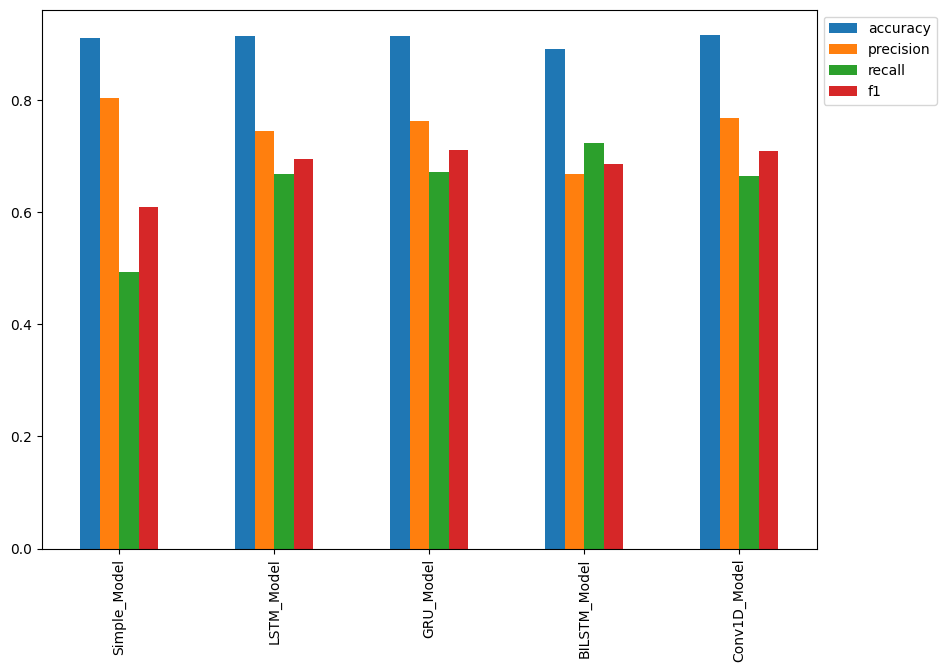

In [60]:
all_models_results.plot(kind='bar',figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

In [61]:
all_models_results.to_csv('all_models_results.csv')